<a href="https://colab.research.google.com/github/shreyashrivastava1/BrainTumorClassification/blob/main/CNN_denseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import itertools
!pip install opendatasets
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')


In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c/data")


Skipping, found downloaded files in "./brain-tumor-mri-images-44c" (use force=True to force download)


In [ ]:
data_dir = '/content/brain-tumor-mri-images-44c'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    # print(fold)
    foldpath = os.path.join(data_dir, fold)
    # print(foldpath)
    filelist = os.listdir(foldpath)
    # print(filelist)

    for file in filelist:
        fpath = os.path.join(foldpath, file)
        # print(fpath)
        filepaths.append(fpath)
        labels.append(fold.split(' ')[0])


FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)
display(df)

,filepaths,labels
0,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma
1,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma
2,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma
3,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma
4,/content/brain-tumor-mri-images-44c/Oligodendr...,Oligodendroglioma
...,...,...
4474,/content/brain-tumor-mri-images-44c/Neurocitom...,Neurocitoma
4475,/content/brain-tumor-mri-images-44c/Neurocitom...,Neurocitoma
4476,/content/brain-tumor-mri-images-44c/Neurocitom...,Neurocitoma
4477,/content/brain-tumor-mri-images-44c/Neurocitom...,Neurocitoma


In [ ]:
df['labels'].value_counts()

labels
Meningioma           874
Astrocitoma          580
_NORMAL              522
Schwannoma           465
Neurocitoma          457
Carcinoma            251
Papiloma             237
Oligodendroglioma    224
Glioblastoma         204
Ependimoma           150
Tuberculoma          145
Meduloblastoma       131
Germinoma            100
Granuloma             78
Ganglioglioma         61
Name: count, dtype: int64

In [ ]:
train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=42, stratify=dummy_df['labels'])

In [ ]:
batch_size = 32
image_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)


Found 3583 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.
Found 447 validated image filenames belonging to 15 classes.


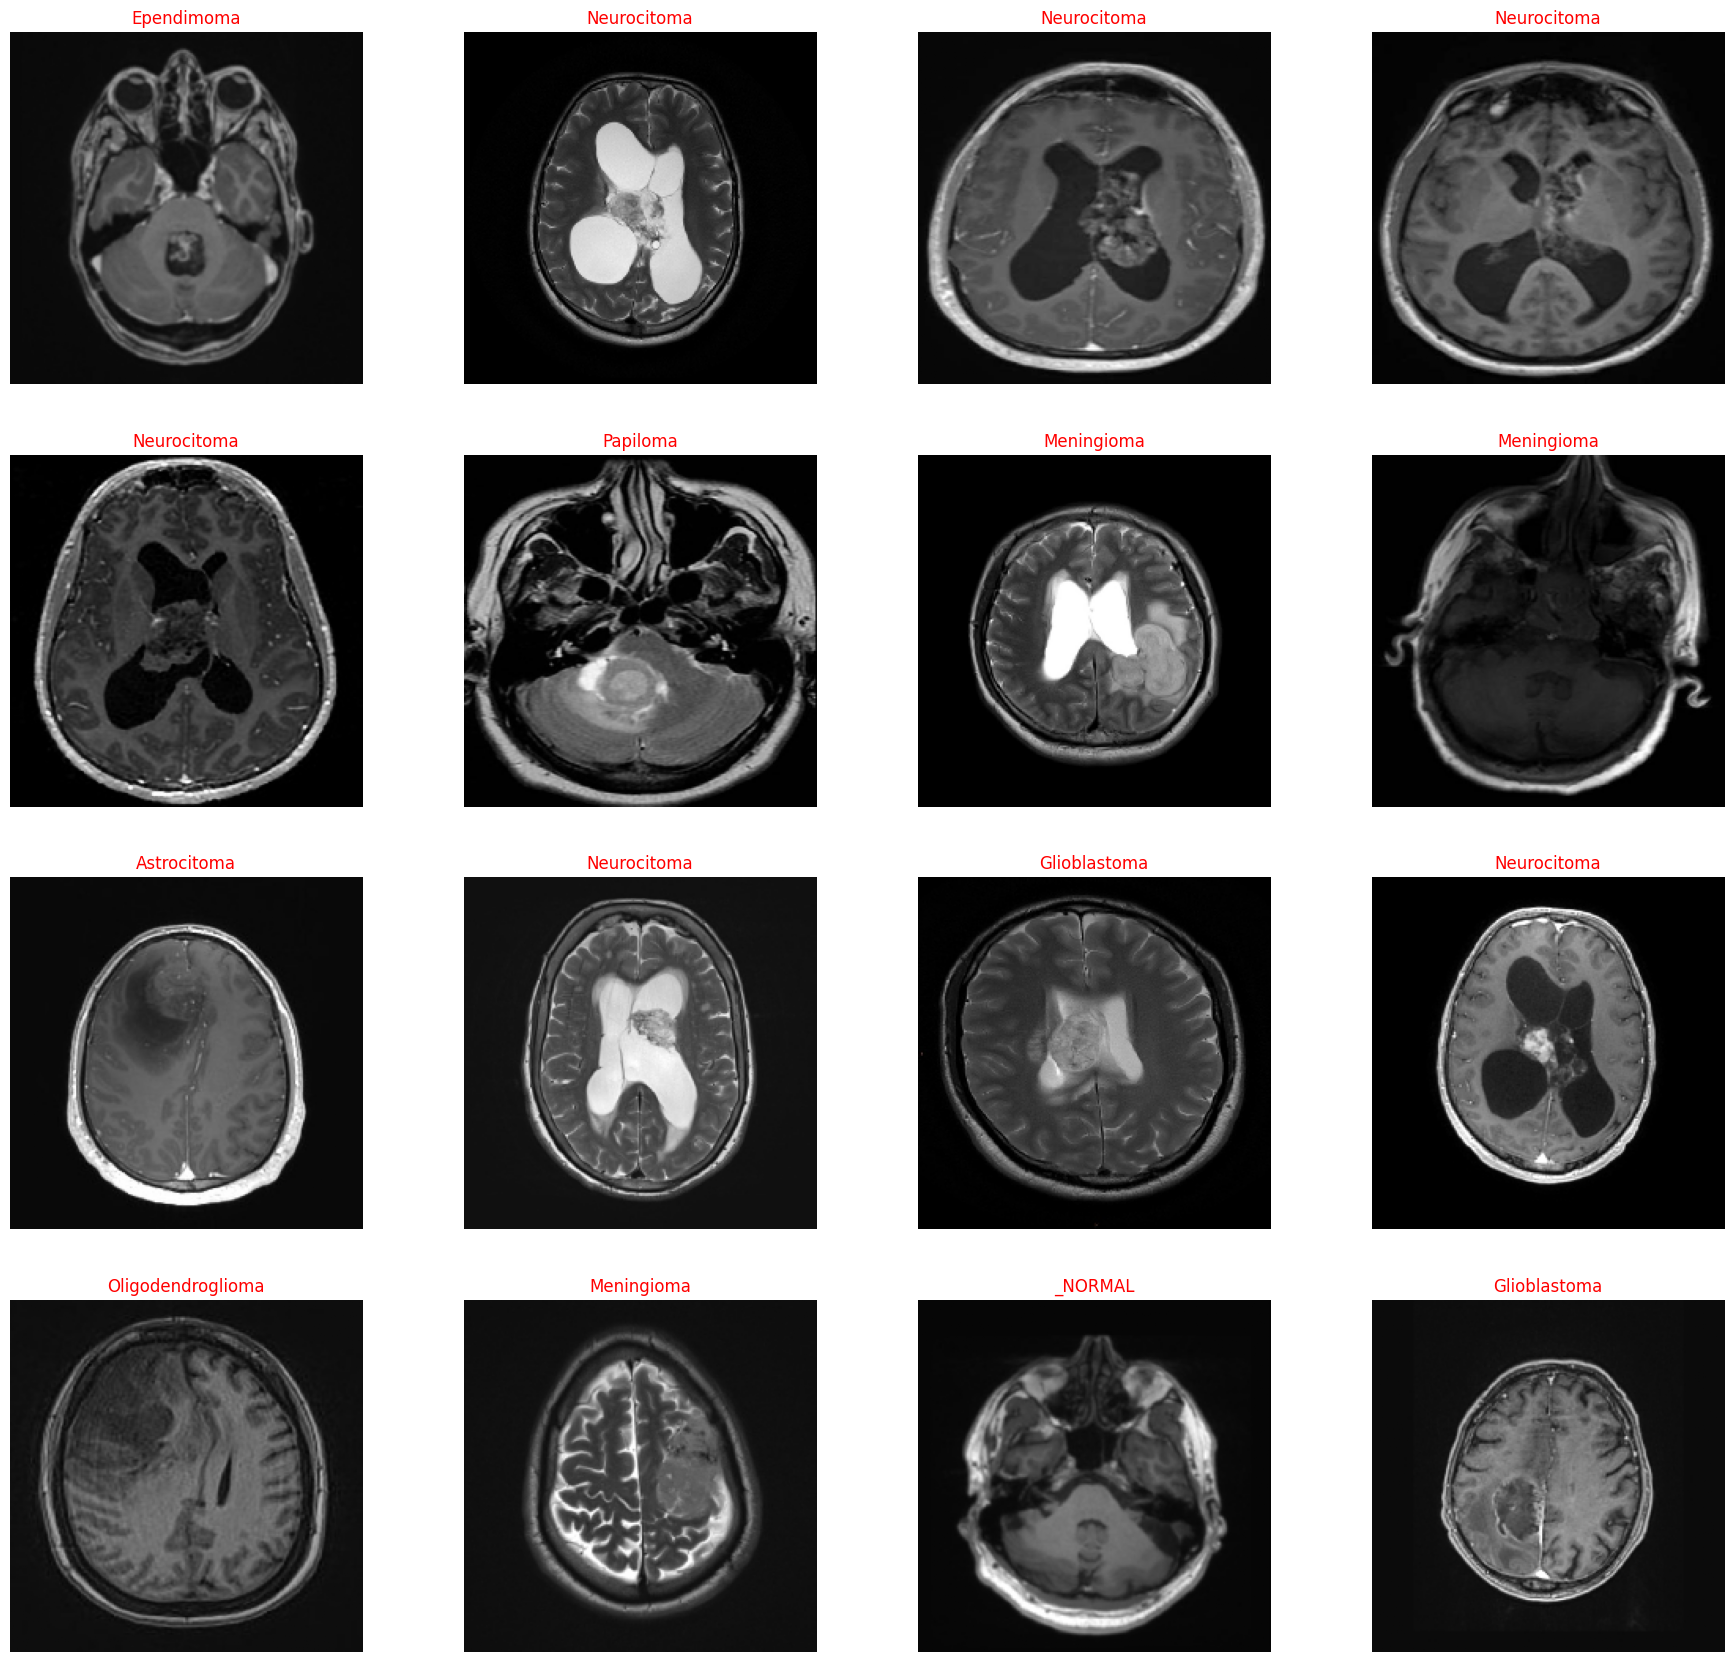

In [ ]:
g_dict = train_gen.class_indices
classes= list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range (16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i]) #[0,0,0,1,0]
    class_name = classes[index]
    plt.title(class_name,c='r', fontsize=12)
    plt.axis('off')
plt.show()

In [ ]:
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))
base_model = tf.keras.applications.DenseNet169(include_top=False,                   # fully connected layers (top) of the model, responsible for classification, are not included.
                                                     weights='imagenet',
                                                     input_shape = image_shape,
                                                     pooling= 'max')

model = Sequential([
    base_model,

    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),         #helps in stabilizing and accelerating the learning process, axis=-1 => normalisation on the feature axis;It means that for each feature, the mean and standard deviation will be computed independently.
                                                                          #momentum: 99% of the previous statistics will be retained. Usually done for stablisation
                                                                          #epsilon: avoid division by zero in the normalisation process[esp if the variance is very small]
    Dense(256, activation='relu'),

    Dropout(rate=0.5),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),])

model.summary()




#activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 flatten_1 (Flatten)         (None, 1664)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 1664)              6656      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               426240    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 15)                3855      
                                                      

In [ ]:
hist= model.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= True )

Epoch 1/20
112/112 [==============================] - 130s 454ms/step - loss: 5.8013 - accuracy: 0.5685 - precision_1: 0.7547 - recall_1: 0.4346 - val_loss: 5.5103 - val_accuracy: 0.5670 - val_precision_1: 0.5995 - val_recall_1: 0.5246
Epoch 2/20
112/112 [==============================] - 49s 440ms/step - loss: 3.3426 - accuracy: 0.8462 - precision_1: 0.9183 - recall_1: 0.7806 - val_loss: 3.1709 - val_accuracy: 0.7946 - val_precision_1: 0.8665 - val_recall_1: 0.7098
Epoch 3/20
112/112 [==============================] - 51s 452ms/step - loss: 2.4097 - accuracy: 0.9378 - precision_1: 0.9646 - recall_1: 0.9048 - val_loss: 2.4316 - val_accuracy: 0.8571 - val_precision_1: 0.8897 - val_recall_1: 0.8281
Epoch 4/20
112/112 [==============================] - 50s 446ms/step - loss: 1.7797 - accuracy: 0.9883 - precision_1: 0.9921 - recall_1: 0.9757 - val_loss: 1.6806 - val_accuracy: 0.9375 - val_precision_1: 0.9671 - val_recall_1: 0.9174
Epoch 5/20
112/112 [==============================] - 49s 4

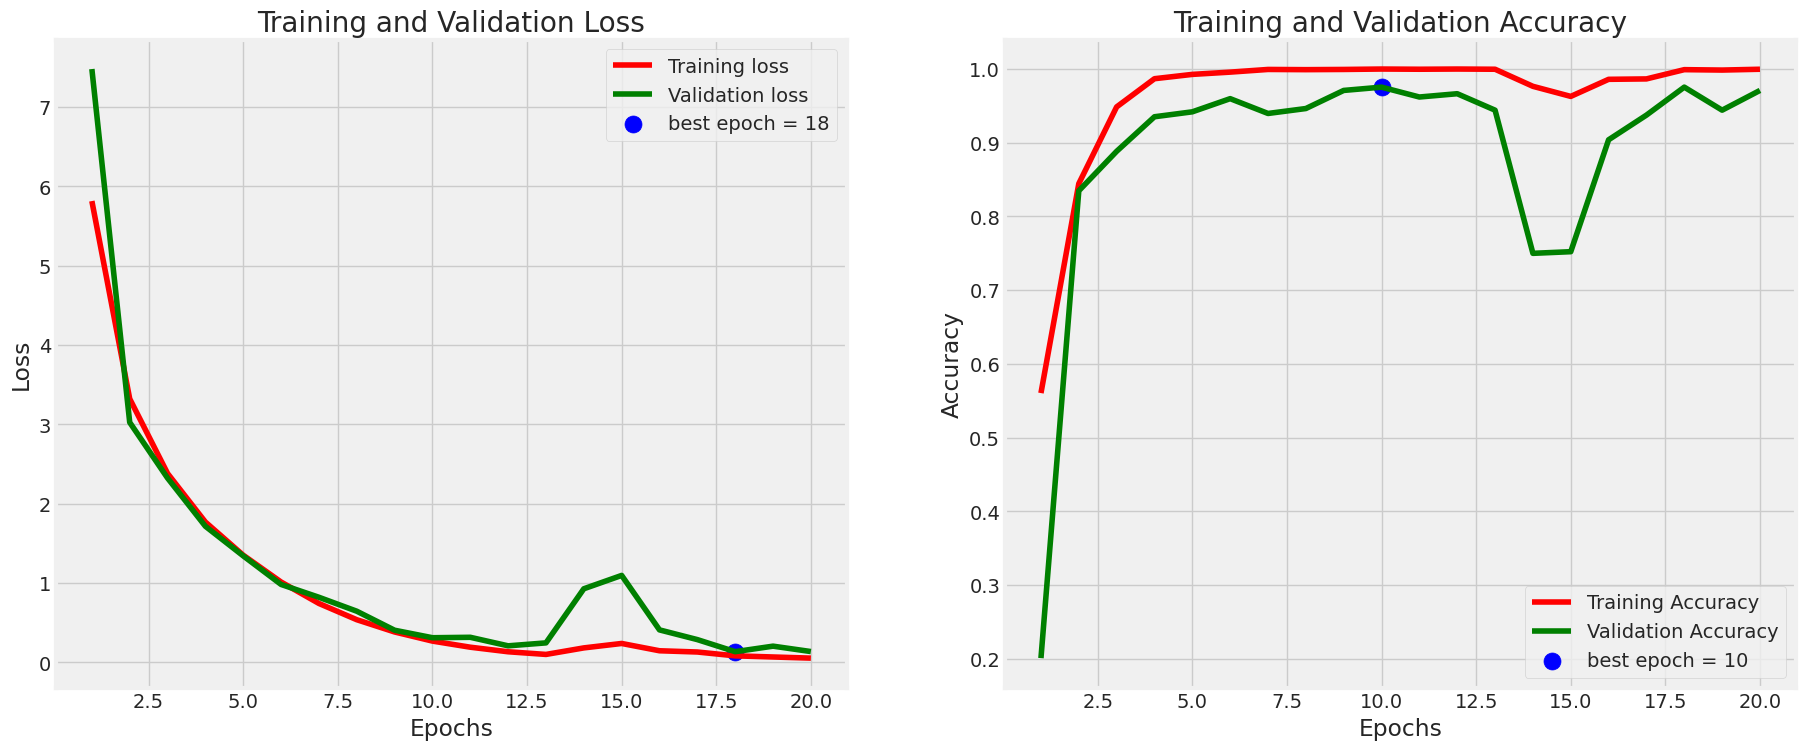

In [ ]:

tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label = 'Training loss')
plt.plot(Epochs, val_loss, 'g', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score= model.evaluate(train_gen)
valid_score= model.evaluate(valid_gen)
test_score=  model.evaluate(test_gen)


In [ ]:


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('=' * 20)
print( )
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('=' * 20)
print( )
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])



Train Loss:  0.0353030189871788
Train Accuracy:  1.0

Valid Loss:  0.12210623174905777
Valid Accuracy:  0.9754464030265808

Test Loss:  0.11302580684423447
Test Accuracy:  0.9776286482810974
